# Exploratory Data Analysis - NYC Taxi Trip Duration

## Problem:
Predict duration of taxi trip at the point when trip starts.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
#importing data
data = pd.read_csv('nyc_taxi_trip_duration.csv')

In [3]:
#first 5 instances using "head()" function
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


## Description of variables
* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **dropoff_datetime** - date and time when the meter was disengaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* **trip_duration** - (target) duration of the trip in seconds

In [4]:
#finding out the shape of the data using "shape" variable: Output (rows, columns)
data.shape

(729322, 11)

In [5]:
#Printing all the columns present in data
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [6]:
#we can drop dropoff_datetime as it already used to calculate trip_duration
data.drop(columns = ['dropoff_datetime'],inplace=True)

In [7]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

## Variable Identification and Typecasting

In [8]:
# A closer look at the data types present in the data
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

* **id**, **vendor_id**, **passenger_count** and **store_and_fwd_flag** should be converted to category
* **pickup_datetime** should be converted to datetime to extract more variables


In [9]:
# converting to category
data['id'] = data['id'].astype('category')
data['vendor_id'] = data['vendor_id'].astype('category')
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].astype('category')

In [10]:
data['passenger_count'] = data['passenger_count'].astype('category')

## New Features
* **Pickup Day of week**
* **Pickup Month**
* **Pickup Hour**
* **Pickup Part of Day**
* **Distance (in km)**
* **Average speed (in kmph)**

In [11]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

In [12]:
data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_hour'] = data['pickup_datetime'].dt.hour

In [13]:
def partofday(hour):
    if hour in range (7,12):
        return "Morning"
    elif hour in range (12,17):
        return "Afternoon"
    elif hour in range (17,22):
        return "Evening"
    else:
        return "Night"

#adding pickup_partofday to new column
data['pickup_partofday'] = data.apply(lambda x : partofday(x['pickup_hour']),axis = 1)

In [14]:
# calculating distance from latitudes and longitudes
# We can approximate by using distance as the crow flies for now

import geopy.distance

def distance(lat1,long1,lat2,long2):
    coord1 = (lat1,long1) 
    coord2 = (lat2,long2)


    result = geopy.distance.geodesic(coord1, coord2).km
    return result

#adding distance(in km) to new column
data['distance'] = data.apply(lambda x : distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)

In [15]:
#adding average speed (in kmph) to new column
data['speed'] = data.apply(lambda x : x['distance']/(x['trip_duration']/3600),axis = 1)

In [16]:
# checking new extracted columns using datetime and coordinates
data[['pickup_datetime','pickup_dayofweek','pickup_month','pickup_hour','pickup_partofday','distance','trip_duration','speed']].head()

,pickup_datetime,pickup_dayofweek,pickup_month,pickup_hour,pickup_partofday,distance,trip_duration,speed
0,2016-02-29 16:40:21,0,2,16,Afternoon,1.199770,400,10.797929
1,2016-03-11 23:35:37,4,3,23,Night,4.123945,1100,13.496548
2,2016-02-21 17:59:33,6,2,17,Evening,7.250436,1635,15.964262
3,2016-01-05 09:44:31,1,1,9,Morning,2.358287,1141,7.440694
4,2016-02-17 06:42:23,2,2,6,Night,4.328155,848,18.374244


In [17]:
#we can drop pickup_datetime now as we have extracted everything we need
data.drop(columns = ['pickup_datetime'],inplace=True)
data.dtypes

id                    category
vendor_id             category
passenger_count       category
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag    category
trip_duration            int64
pickup_dayofweek         int64
pickup_month             int64
pickup_hour              int64
pickup_partofday        object
distance               float64
speed                  float64
dtype: object

In [18]:
data['pickup_partofday'] = data['pickup_partofday'].astype('category')
data['pickup_dayofweek'] = data['pickup_dayofweek'].astype('category')
data['pickup_month'] = data['pickup_month'].astype('category')
data['pickup_hour'] = data['pickup_hour'].astype('category')
data.dtypes

id                    category
vendor_id             category
passenger_count       category
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag    category
trip_duration            int64
pickup_dayofweek      category
pickup_month          category
pickup_hour           category
pickup_partofday      category
distance               float64
speed                  float64
dtype: object

## Missing Values

In [19]:
data.isnull().sum()

id                    0
vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_dayofweek      0
pickup_month          0
pickup_hour           0
pickup_partofday      0
distance              0
speed                 0
dtype: int64

No missing values!

## Univariate Analysis: Numerical Variables

In [20]:
# Numerical datatypes
num_columns = data.select_dtypes(include=['int64','float64']).columns

In [21]:
data[num_columns].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,speed
count,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05,729322.000000,729322.000000
mean,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02,3.442464,14.424310
std,0.069754,0.033594,0.069588,0.036037,3.864626e+03,4.356668,12.343552
min,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00,0.000000,0.000000
25%,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02,1.233153,9.127319
50%,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02,2.096073,12.799458
75%,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03,3.875828,17.844018
max,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06,1240.510256,5638.682980


* -121 longitude is on the west coast. similarly -65 would be in the ocean.
* distance 0 needs to be investigated further.
* speed of 5000 kmph is also not possible.

### **Pickup Longitudes and Latitudes**

In [23]:
data['pickup_latitude'].sort_values(ascending=False)

244913    51.881084
545950    43.911762
631302    43.486885
533843    43.139652
170261    42.458942
            ...    
423484    38.898849
638951    37.777771
421819    37.389381
485701    35.310307
697620    34.712234
Name: pickup_latitude, Length: 729322, dtype: float64

In [24]:
data['pickup_longitude'].sort_values(ascending=False)

423573    -65.897385
170261    -70.511902
545950    -71.881645
485701    -72.074333
315560    -72.421227
             ...    
423484    -77.039436
638951    -77.896019
267279    -78.547401
200522    -79.569733
421819   -121.933342
Name: pickup_longitude, Length: 729322, dtype: float64

In [25]:
# remove the longitude -121 as it is on the complete opposite coast.
data.drop(421819, inplace = True)

### **Dropoff Longitudes and Latitudes**

In [27]:
data['dropoff_latitude'].sort_values(ascending=False)

621372    43.921028
545950    43.911762
631302    43.486885
533843    43.139652
170261    42.458942
            ...    
423484    38.898849
695286    38.478298
638951    37.777771
485701    35.173546
697620    32.181141
Name: dropoff_latitude, Length: 729321, dtype: float64

In [28]:
data['dropoff_longitude'].sort_values(ascending=False)

423573   -65.897385
170261   -70.511902
545950   -71.881645
485701   -72.022408
315560   -72.421227
            ...    
638951   -77.896019
621372   -79.518616
267279   -79.786133
441429   -79.817978
200522   -80.355431
Name: dropoff_longitude, Length: 729321, dtype: float64

### **Trip Duration**

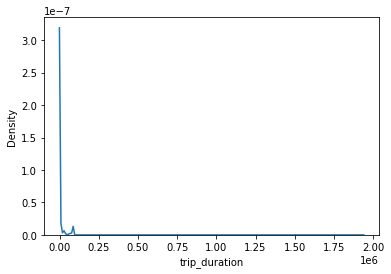

In [29]:
sns.kdeplot(data=data,x = 'trip_duration');

In [30]:
#outliers
data['trip_duration'].sort_values(ascending = False)

21813     1939736
259437      86391
119185      86387
177225      86378
496391      86377
           ...   
672240          1
533760          1
70318           1
622664          1
296874          1
Name: trip_duration, Length: 729321, dtype: int64

In [31]:
#drop outlier
data.drop(21813, inplace = True)

In [32]:
#looking at trips with really short duration
data.loc[data.trip_duration<30][['trip_duration','distance']].describe()

,trip_duration,distance
count,2375.000000,2375.000000
mean,13.343579,0.042930
std,8.284933,0.181323
min,1.000000,0.000000
25%,6.000000,0.000000
50%,12.000000,0.003193
75%,20.000000,0.028784
max,29.000000,6.906459


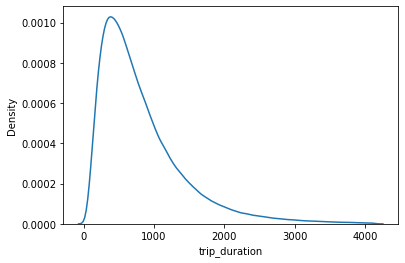

In [33]:
sns.kdeplot(data=data.loc[(data.trip_duration<data.trip_duration.quantile(0.995))&(data.trip_duration>data.trip_duration.quantile(0.005))],x = 'trip_duration');

Most trips are short and under 30 minutes

### **Distance**

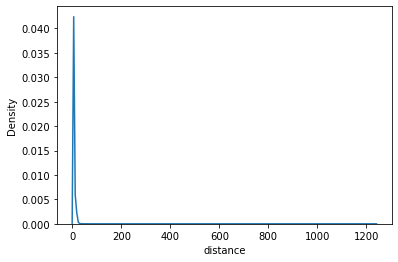

In [34]:
sns.kdeplot(data=data,x = 'distance');

In [35]:
#outliers
data['distance'].sort_values(ascending = False)

244913    1240.510256
621372     575.600259
441429     546.924490
654569     320.445202
697620     314.260625
             ...     
249735       0.000000
489050       0.000000
249766       0.000000
92736        0.000000
688491       0.000000
Name: distance, Length: 729320, dtype: float64

In [36]:
#drop outlier
data.loc[244913]

id                      id2306955
vendor_id                       1
passenger_count                 1
pickup_longitude       -72.809669
pickup_latitude         51.881084
dropoff_longitude      -73.987228
dropoff_latitude        40.750599
store_and_fwd_flag              N
trip_duration                 792
pickup_dayofweek                5
pickup_month                    5
pickup_hour                    18
pickup_partofday          Evening
distance              1240.510256
speed                  5638.68298
Name: 244913, dtype: object

This should be dropped as the speed is impossible

In [37]:
data.drop(244913,inplace=True);

In [38]:
#looking at trips with distance 0
data.loc[data.distance<0.5][['distance']].value_counts()

distance
0.000000    2901
0.000424       2
0.416841       1
0.416909       1
0.416898       1
            ... 
0.266194       1
0.266186       1
0.266182       1
0.266178       1
0.499979       1
Length: 21465, dtype: int64

These may be due to
* Round trips
* something to do with connectivity - store and forward flag
* cancelled trips

Needs to be investigated further

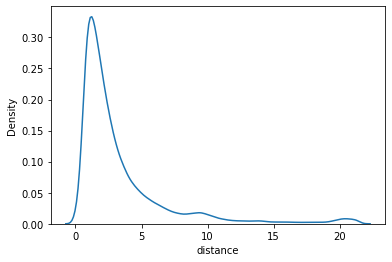

In [39]:
sns.kdeplot(data=data.loc[(data.distance<data.distance.quantile(0.995))&(data.distance>data.distance.quantile(0.005))],x = 'distance');

Most trips are shorter than 5 kms.
There are two small peaks near 9.5km and 20.5km. 
The 9.5 one is probably trips to airport.

### **Speed**

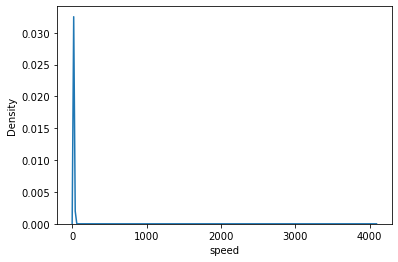

In [40]:
sns.kdeplot(data=data,x = 'speed');

In [41]:
#outliers
data['speed'].sort_values(ascending = False)

654569    4090.789812
67268     1410.612913
146590    1408.750365
267279    1355.140122
697620    1292.957998
             ...     
584734       0.000000
319569       0.000000
250354       0.000000
319506       0.000000
168202       0.000000
Name: speed, Length: 729319, dtype: float64

In [42]:
#checking speeds above 200kmph
data.loc[data.speed>200]['id'].count()

35

These are few in number and can be dropped.

In [43]:
data.drop(data.loc[data.speed>200].index,inplace=True);

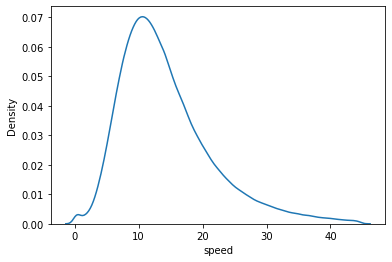

In [44]:
sns.kdeplot(data=data.loc[(data.speed<data.speed.quantile(0.995))&(data.speed>data.speed.quantile(0.005))],x = 'speed');

Our variable underestimates the actual speed.

Most trips have average speed less than 25kmph which is expected in a big metropolis with frequent stops.
Interestingly, there is no second peak like in the distance plot to denote a presumably higher average speed to the airport. Would be interesting to see if the trip to the airport is faster or not.

The small peak near 0 is probably due to round trips which have short displacement and high trip duration.

## Univariate Analysis : Categorical Variables ##

In [45]:
data.select_dtypes(exclude=['int64','float64']).dtypes

id                    category
vendor_id             category
passenger_count       category
store_and_fwd_flag    category
pickup_dayofweek      category
pickup_month          category
pickup_hour           category
pickup_partofday      category
dtype: object

In [46]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var):

  '''
  Univariate_Analysis_categorical
  takes a variable (category) and plot/print the value_counts and barplot.
  '''
  plt.figure(figsize = (14,10), dpi = 100)

  norm_count = data[var].value_counts(normalize = True)
  n_uni = data[var].nunique()

  #Plotting the variable with every information
  sns.barplot(norm_count, norm_count.index, order = norm_count.index.sort_values(ascending=True))
  plt.xlabel('fraction/percent', fontsize = 20)
  plt.ylabel('{}'.format(var), fontsize = 20)
  plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count),fontsize = 20)

### **Passenger Count**

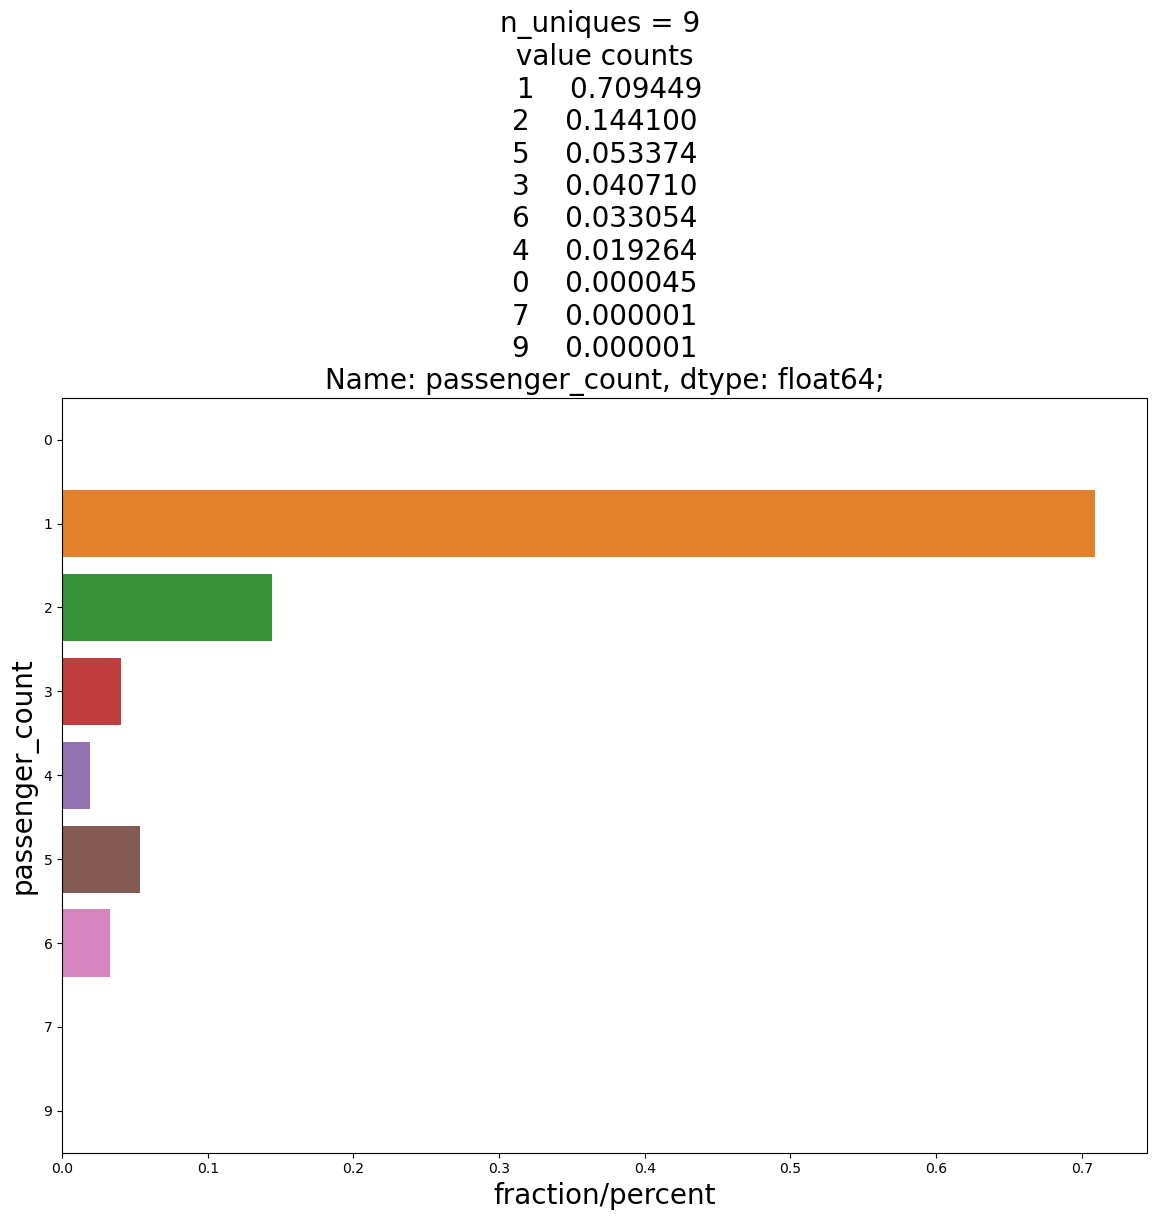

In [47]:
UVA_category(data, 'passenger_count');

Passenger count of 0,7 and 9 can just be removed as outliers.

In [48]:
data.drop(data.loc[(data.passenger_count==0)|(data.passenger_count==7)|(data.passenger_count==9)].index,inplace=True)

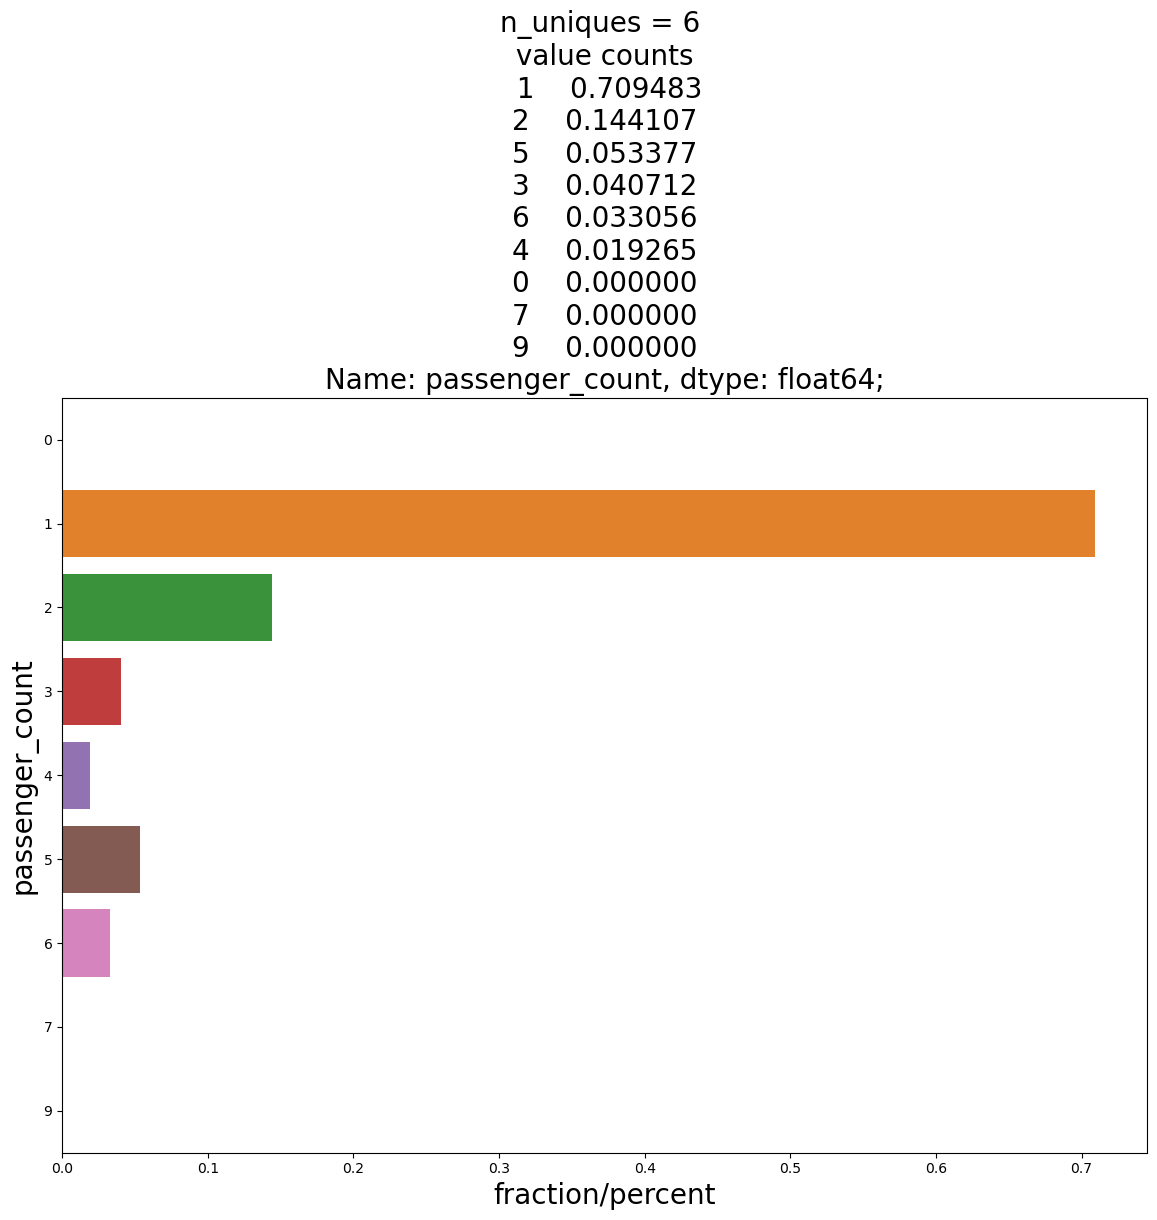

In [49]:
UVA_category(data, 'passenger_count');

In [104]:
data.passenger_count = data.passenger_count.astype('int64')
data.passenger_count = data.passenger_count.astype('category')

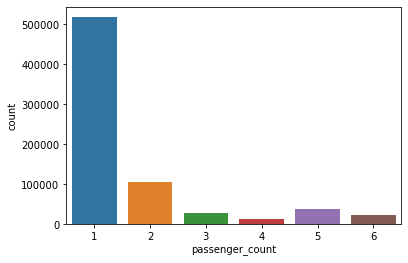

In [105]:
sns.countplot(data=data, x= 'passenger_count');

* Most trips have a single passenger.

### **Vendor ID**

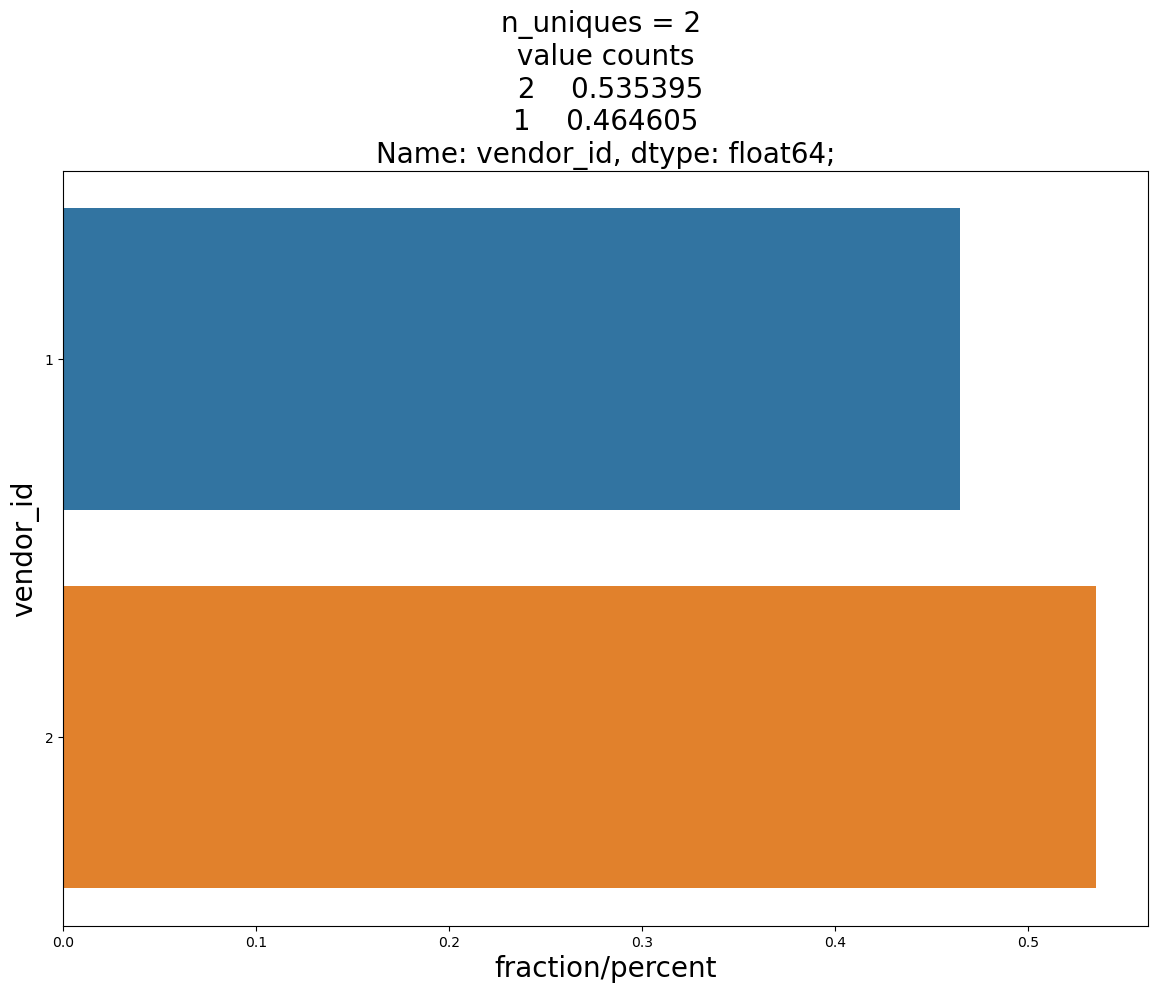

In [52]:
UVA_category(data,'vendor_id');

Nothing too remarkable

### Store and Fwd Flag

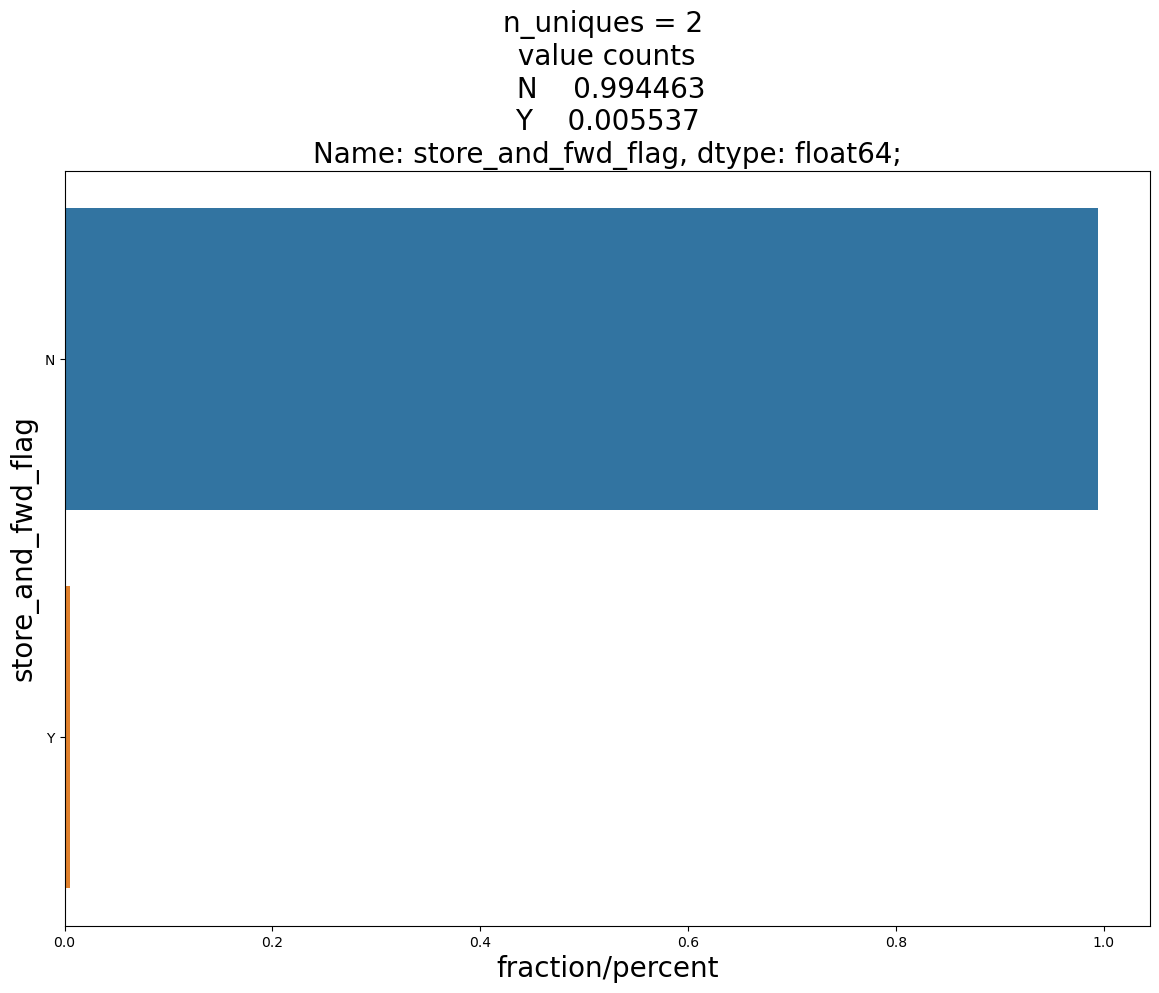

In [53]:
UVA_category(data,'store_and_fwd_flag');

* Almost all trips do not storem and forward.
* Trips which do store and forward might explain trips with 0 distance due to some error

### Pickup Day of Week

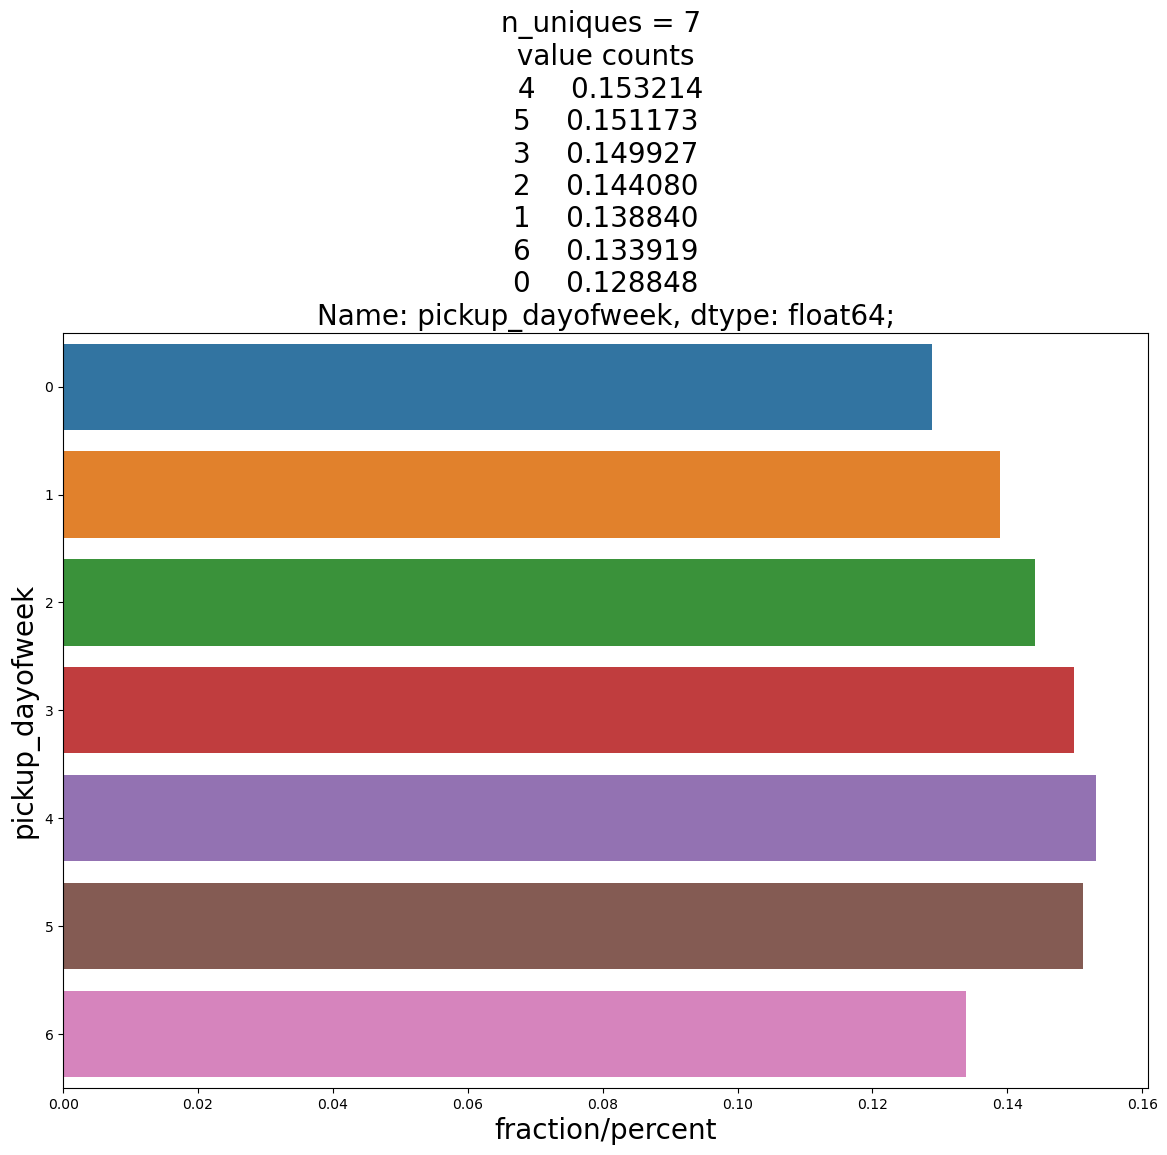

In [54]:
UVA_category(data,'pickup_dayofweek');

* Friday and Saturday are the busiest days.
* Monday and Sunday are the least busy.
* The tendency to use a taxi generally increases as the week goes on and drops on Sunday due to the weekend.

### Pickup  Month

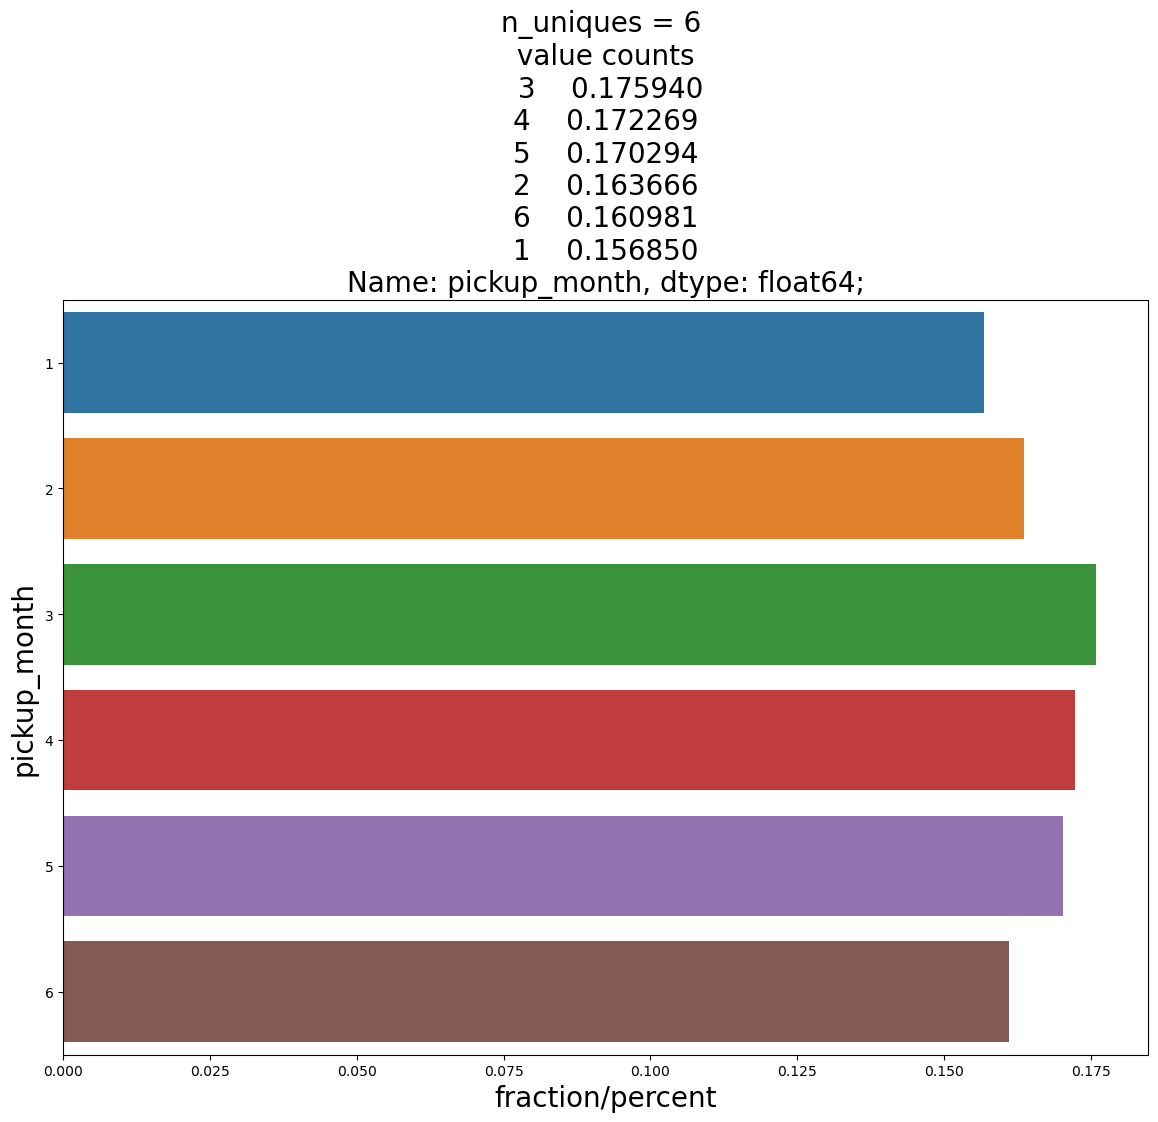

In [55]:
UVA_category(data,'pickup_month');

There more trips during March/April than January or June maybe due to less extreme weather in spring.

### Pickup Hour

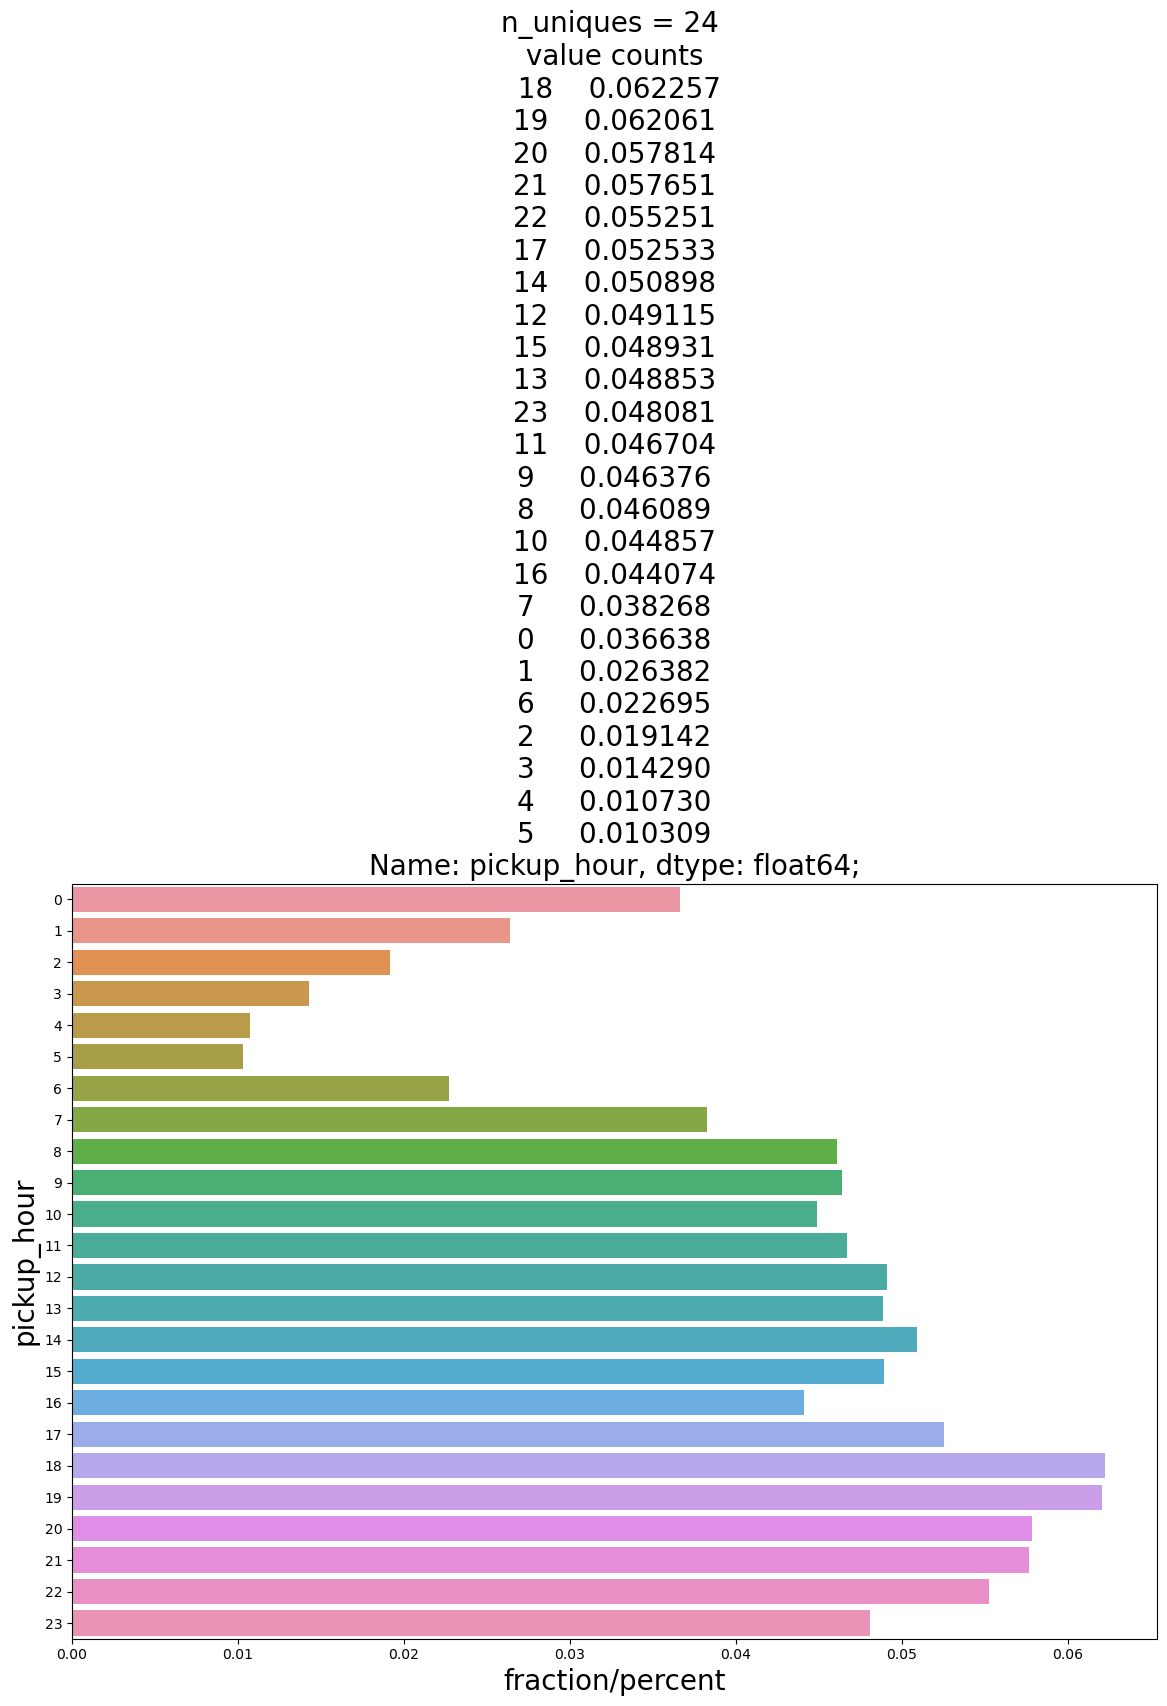

In [56]:
UVA_category(data, 'pickup_hour');

* The busiest hours are in the evening to early night from 5:00pm to 11:00pm when people return from work.
* Late night and early morning from 2:00am to 6:00am are least busy as is expected.

### Pickup Part of Day

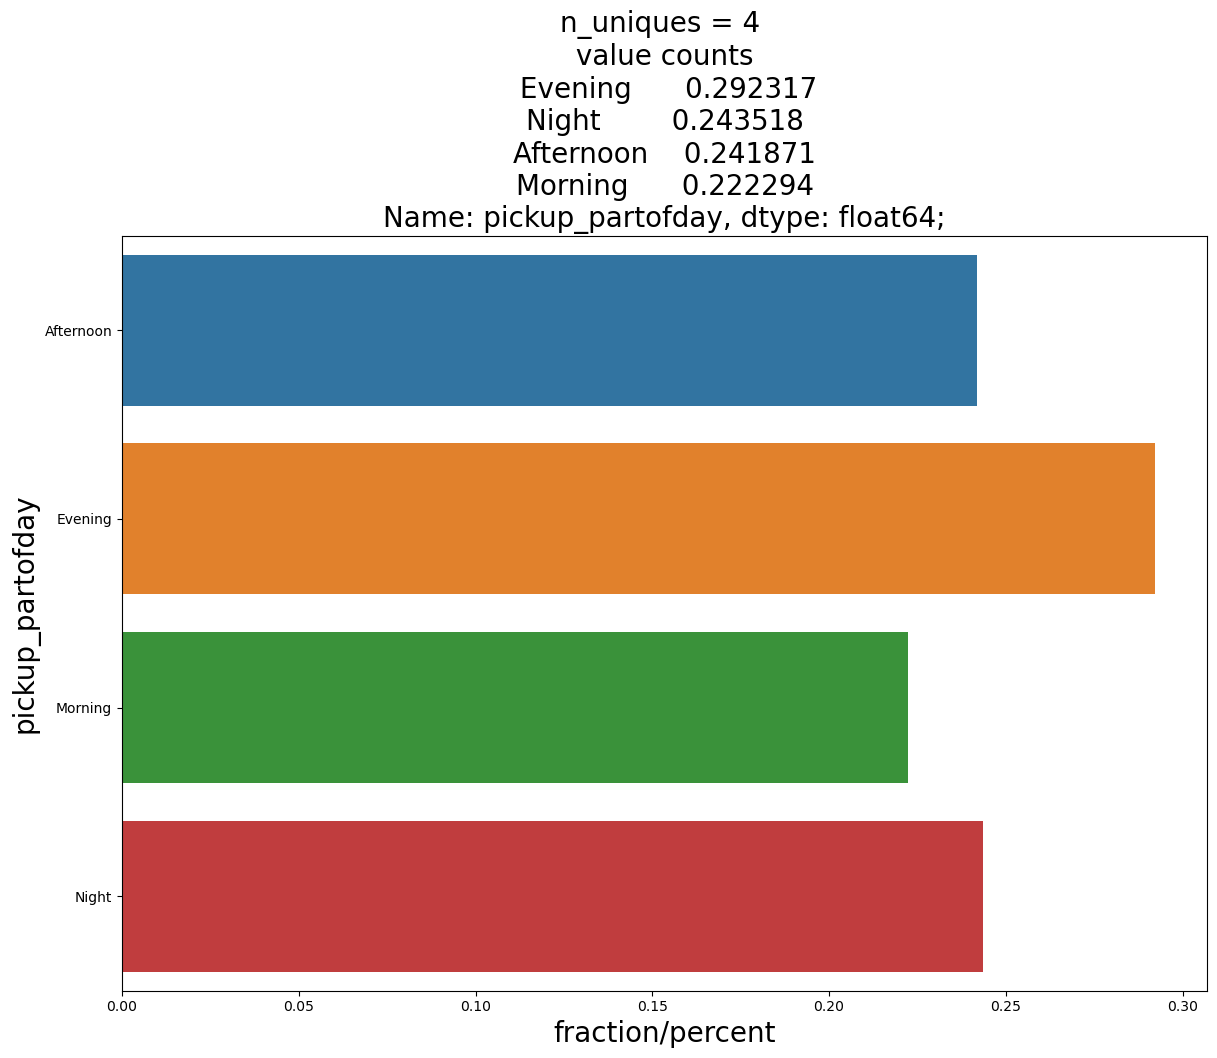

In [57]:
UVA_category(data, 'pickup_partofday');

* Evenings are the busiest as we saw earlier.
* Nights are the least busy (we defined night to be 9 hours long while the other three categories are just 5 hours long.)

## Univariate Analysis: Outliers

**We removed a few extreme outliers earlier but there are still many outliers in the numeric variables.**

In [58]:
# custom function for easy outlier analysis

def UVA_outlier(data, i, h = 1, include_outlier = True):
    '''
    Univariate_Analysis_outlier:
    takes a variable (INTEGER and FLOAT) 
    and plot/print boplot and descriptives\n
  
    data : dataframe from which to plot from\n
    i : continuous variable\n
    include_outlier : {bool} whether to include outliers or not, 
    default = True\n
    '''
    plt.figure(figsize = (5,2.5))
  
    # calculating descriptives of variable
    quant25 = data[i].quantile(0.25)
    quant75 = data[i].quantile(0.75)
    IQR = quant75 - quant25
    med = data[i].median()
    whis_low = med-(1.5*IQR)
    whis_high = med+(1.5*IQR)

    # Calculating Number of Outliers
    outlier_high = len(data[i][data[i]>whis_high])
    outlier_low = len(data[i][data[i]<whis_low])

    if include_outlier == True:
      print(include_outlier)
      #Plotting the variable with every information
      sns.boxplot(data[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'
          .format(round(IQR,2),round(med,2),(round(quant25,2),
          round(quant75,2)),(outlier_low,outlier_high)))
      
    else:
      # replacing outliers with max/min whisker
      def replace_val(x, whis_high, whis_low, h):
            if  x>whis_high:
                return(whis_high+h)
            elif x<whis_low:
                return (whis_low-h)
            else:
                return x
      data2 = data.copy()
        
      data2['new'] = data2.apply(lambda x : replace_val(x[i], whis_high, whis_low,h), axis = 1)
      
      # plotting without outliers
      sns.boxplot(data2['new'], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'
          .format(round(IQR,2),round(med,2),(round(quant25,2),
          round(quant75,2)),(outlier_low,outlier_high)))

### Pickup Latitudes and Longitudes

True


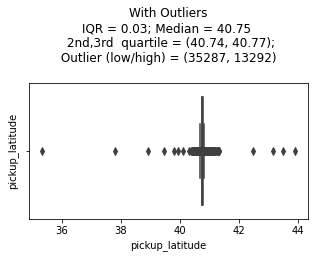

In [59]:
UVA_outlier(data, 'pickup_latitude');

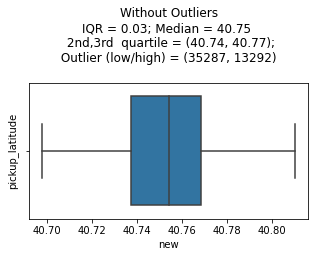

In [60]:
UVA_outlier(data, 'pickup_latitude',h = 0.01, include_outlier=False);

True


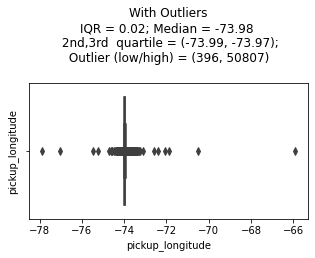

In [61]:
UVA_outlier(data, 'pickup_longitude');

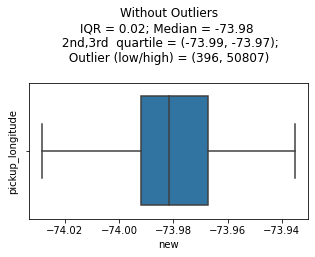

In [62]:
UVA_outlier(data, 'pickup_longitude', h=0.01, include_outlier=False);

Significant number of outliers are present.

### Dropoff Latitudes and Longitudes

True


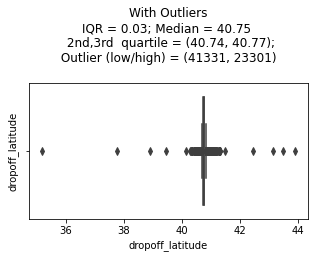

In [63]:
UVA_outlier(data, 'dropoff_latitude');

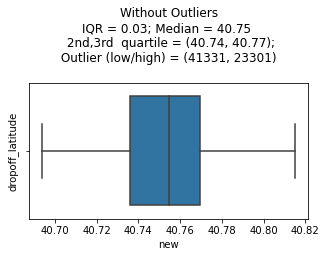

In [64]:
UVA_outlier(data, 'dropoff_latitude',h = 0.01, include_outlier=False);

True


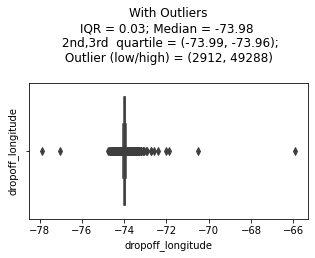

In [65]:
UVA_outlier(data, 'dropoff_longitude');

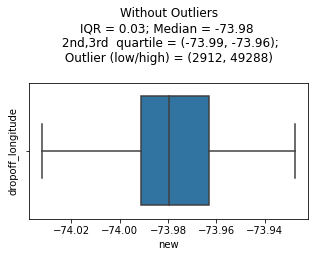

In [66]:
UVA_outlier(data, 'dropoff_longitude', h=0.01, include_outlier=False);

Significant number of outliers are present.

### Trip Duration

True


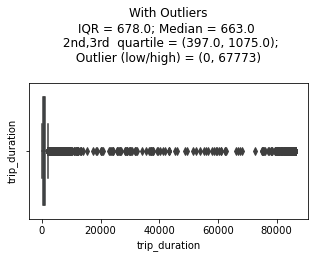

In [67]:
UVA_outlier(data, 'trip_duration');

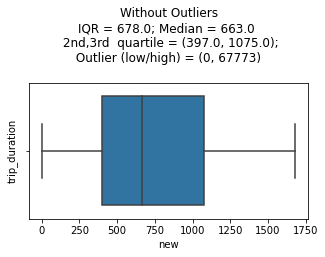

In [68]:
UVA_outlier(data, 'trip_duration', include_outlier = False);

Significant number of outliers are present.

### Distance

True


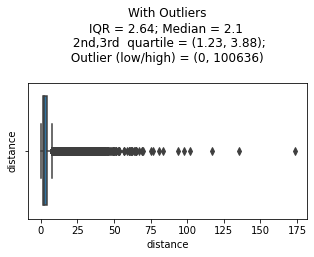

In [69]:
UVA_outlier(data, 'distance');

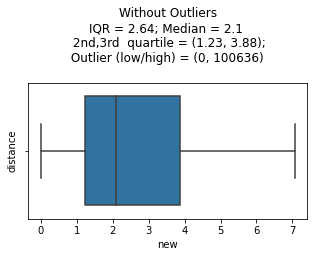

In [70]:
UVA_outlier(data, 'distance', include_outlier = False);

Very High number of outliers are present.

### Speed

True


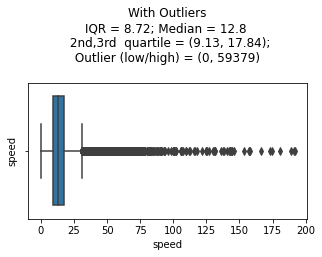

In [71]:
UVA_outlier(data, 'speed');

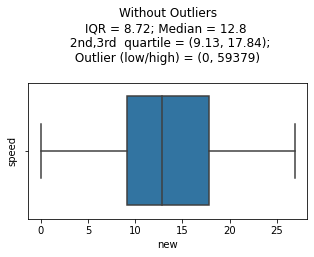

In [72]:
UVA_outlier(data, 'speed', include_outlier = False);

Significant number of outliers are present.

## Investigation directions from Univariate Analysis
1. id variable can be dropped.
2. Can the store and forward flag explain trips with distance 0?
3. Do all trips with distance 0 have large enough duration for they being round trips?
4. Do trips to and from airport explain second peaks in distance kde plot?
5. Do trips to and from airport have similar speeds which would warrant a second peak in the speed kde plot?
6. Do trips outside Manhattan have higher speed than trips with pickup or dropoff in Manhattan?

In [73]:
data.drop(columns=['id'],inplace=True);

## Bivariate Analysis : Continuous-Continuous

In [106]:
# isolating numerical datatypes
numerical = data.select_dtypes(include=['int64','float64'])[:]
numerical.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_duration          int64
distance             float64
speed                float64
dtype: object

### Correlation Matrix

In [107]:
# calculating correlation
correlation = numerical.corr()
s = pd.DataFrame(correlation.unstack().sort_values(ascending=False), 
                 columns = ['pearson_correlation'])
N  = len(data)
import math
s = s.loc[s.pearson_correlation<1]
s = s.iloc[::2]

#calculating whether the correlation is significant
s['t'] = s.apply(lambda x : x['pearson_correlation']*math.sqrt(N-2)/
                 math.sqrt(1-(x['pearson_correlation'])**2), axis = 1)
from scipy.stats import t as t_dist
s['p'] = s.apply(lambda x : 2*(1-t_dist.cdf(abs(x['t']), N-2)), axis = 1)

#showing only significant correlations
s.loc[s.p<0.05, ['pearson_correlation']]

pearson_correlation
speed             distance                      0.555725
pickup_latitude   dropoff_latitude              0.485885
pickup_longitude  distance                      0.476025
                  dropoff_longitude             0.353543
dropoff_longitude distance                      0.337278
speed             pickup_longitude              0.270539
dropoff_longitude speed                         0.262271
distance          trip_duration                 0.167515
dropoff_longitude dropoff_latitude              0.130729
trip_duration     pickup_longitude              0.071426
pickup_latitude   dropoff_longitude             0.059899
dropoff_latitude  pickup_longitude              0.052652
dropoff_longitude trip_duration                 0.045725
speed             dropoff_latitude              0.010519
trip_duration     dropoff_latitude             -0.037784
                  pickup_latitude              -0.050002
speed             trip_duration                -0.052393
pickup_latitude   pickup_longitude             -0.108906
                  speed                        -0.115386
distance          dropoff_latitude             -0.151054
                  pickup_latitude              -0.298486

### Heatmap

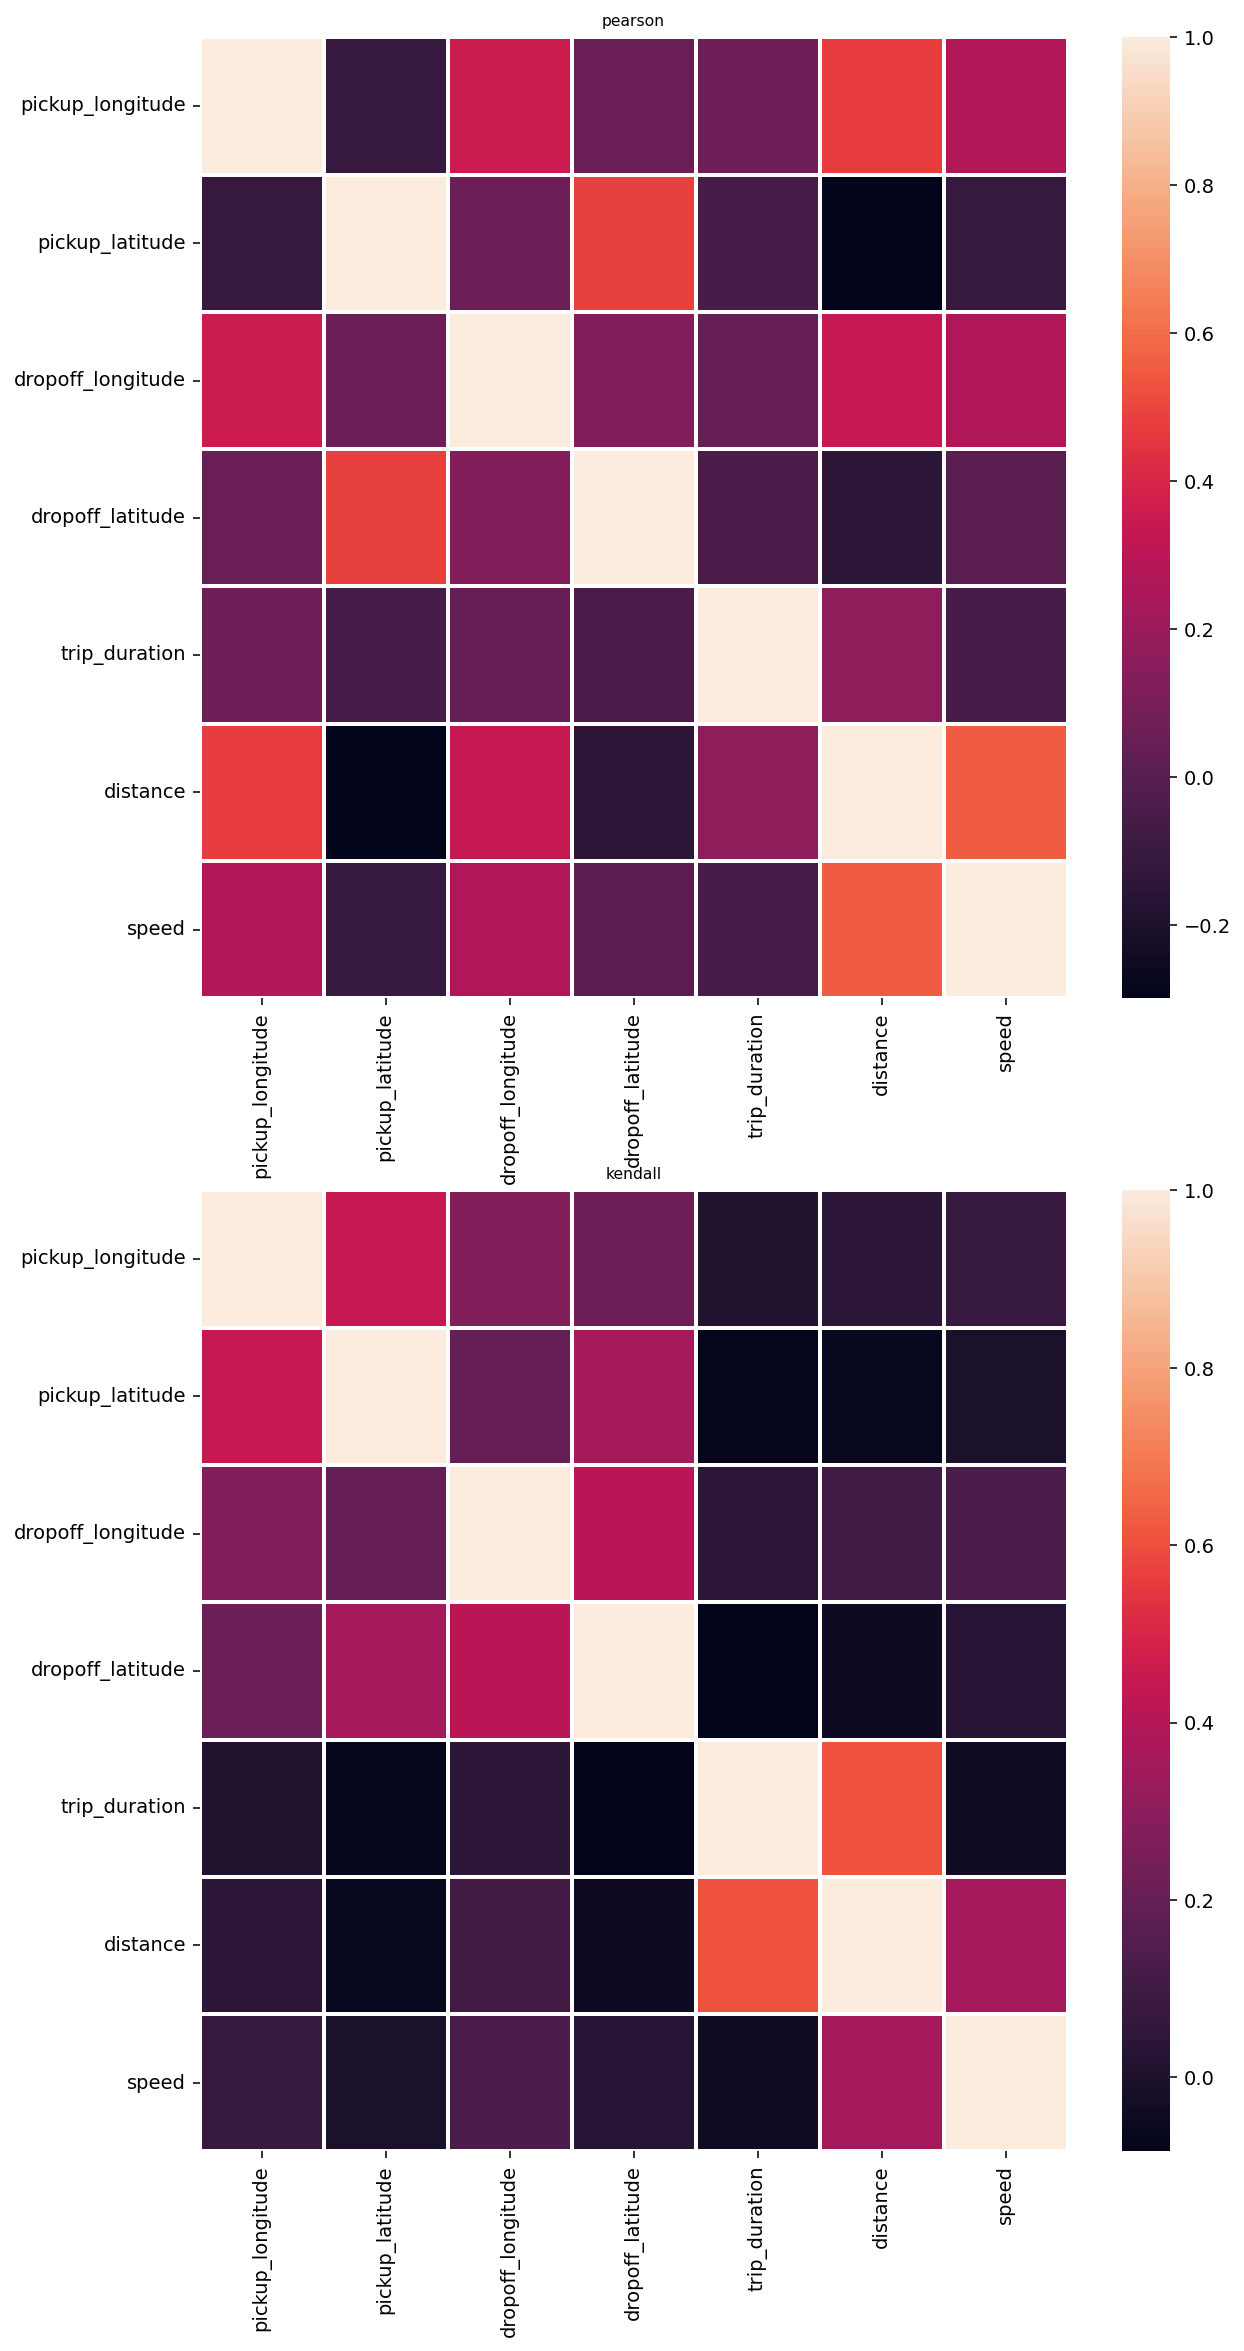

In [108]:
# plotting heatmap using pearson's and kendall's method
plt.figure(figsize=(10,20), dpi=140)
for j,i in enumerate(['pearson','kendall']):
  plt.subplot(2,1,j+1)
  correlation = numerical.corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=8)

**Inferences:**
* Speed and distance are highly correlated (0.55). Therefore, distance and trip duration are only slightly correlated (0.17).
* Pickup longitude, drop longitude, speed and distance are positively correlated to each other therefore, trips to and from the airport are indeed faster.
* Pickup and Dropoff latitude are positively correlated to each other but are both negatively correlated to speed and distance.
* The above two points together show that trips in and around Manhattan are shorter in distance but slower in speed and trips away from Manhattan are longer in distance but also faster which again explains why trip duration is only slightly correlated with distance. 

### Pickup Location

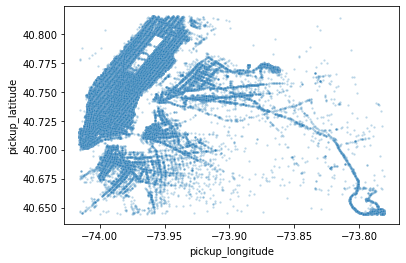

In [22]:
# after removing outliers
sns.scatterplot(data=data.loc[(data.pickup_latitude>data.pickup_latitude.quantile(0.005))
                              &(data.pickup_latitude<data.pickup_latitude.quantile(0.995))
                              &(data.pickup_longitude>data.pickup_longitude.quantile(0.005))
                              &(data.pickup_longitude<data.pickup_longitude.quantile(0.995))], 
                x = 'pickup_longitude', 
                y = 'pickup_latitude',
                **{'alpha':0.3,'s':5});

Most pickups are in and around Manhattan with a second cluster around the airport in the South East.

### Dropoff Location

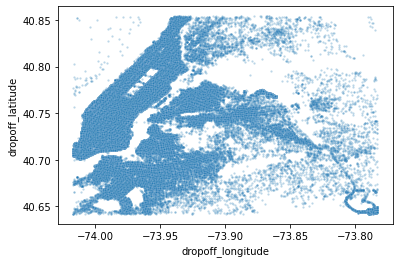

In [26]:
# after removing outliers
sns.scatterplot(data=data.loc[(data.dropoff_latitude>data.dropoff_latitude.quantile(0.005))
                              &(data.dropoff_latitude<data.dropoff_latitude.quantile(0.995))
                              &(data.dropoff_longitude>data.dropoff_longitude.quantile(0.005))
                              &(data.dropoff_longitude<data.dropoff_longitude.quantile(0.995))], 
                x = 'dropoff_longitude', 
                y = 'dropoff_latitude',
                **{'alpha':0.3,'s':5});

Dropoffs are much more spread out. Therefore, a significant number of people use taxis to just go from manhattan to other parts of new york and not both ways.

## Bivariate Analysis: Continuous-Categorical

We analyse Distance, Speed and Trip Duration for all the categorical variables

### Helper Functions

In [89]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

In [91]:
def BVA_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.std()
  
  #calculating p-values
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('z-test p-value = {}\n {}'.format(z_p_val,table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')
  

In [121]:
def BVA(data, cat):
    plt.figure(figsize = (20,10))
    plt.subplot(1,3,1)
    sns.barplot(data = data, x = cat, y = 'distance')
    plt.subplot(1,3,2)
    sns.barplot(data = data, x = cat, y = 'speed')
    plt.subplot(1,3,3)
    sns.barplot(data = data, x = cat, y = 'trip_duration')

### Vendor ID

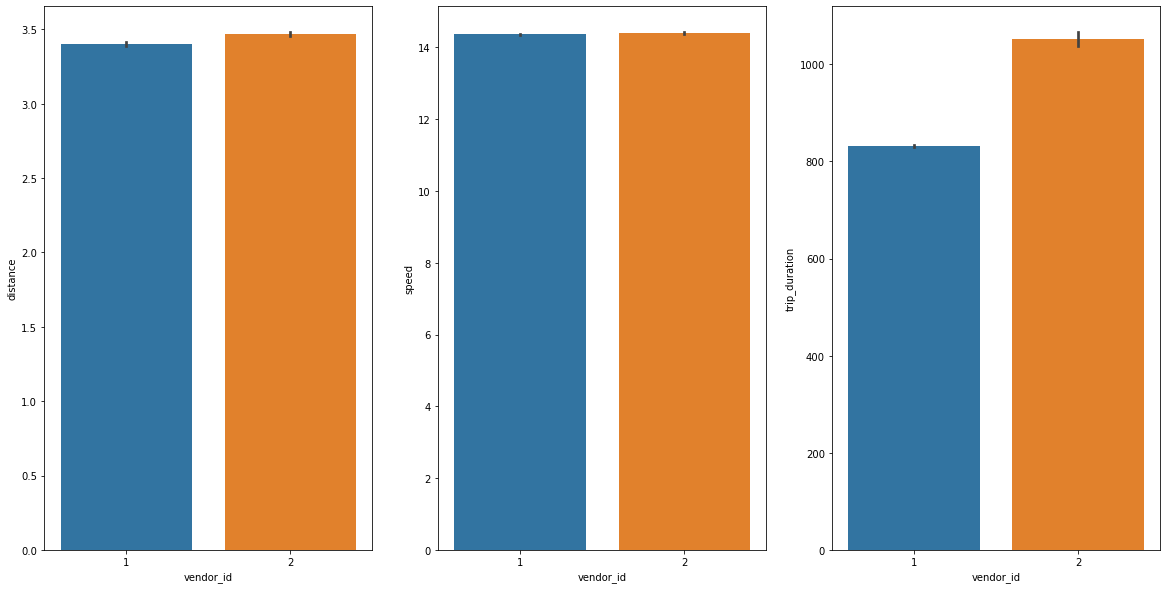

In [122]:
BVA(data, 'vendor_id')

Vendor 2 has longer trips compared to Vendor 1

### Store and Forward Flag

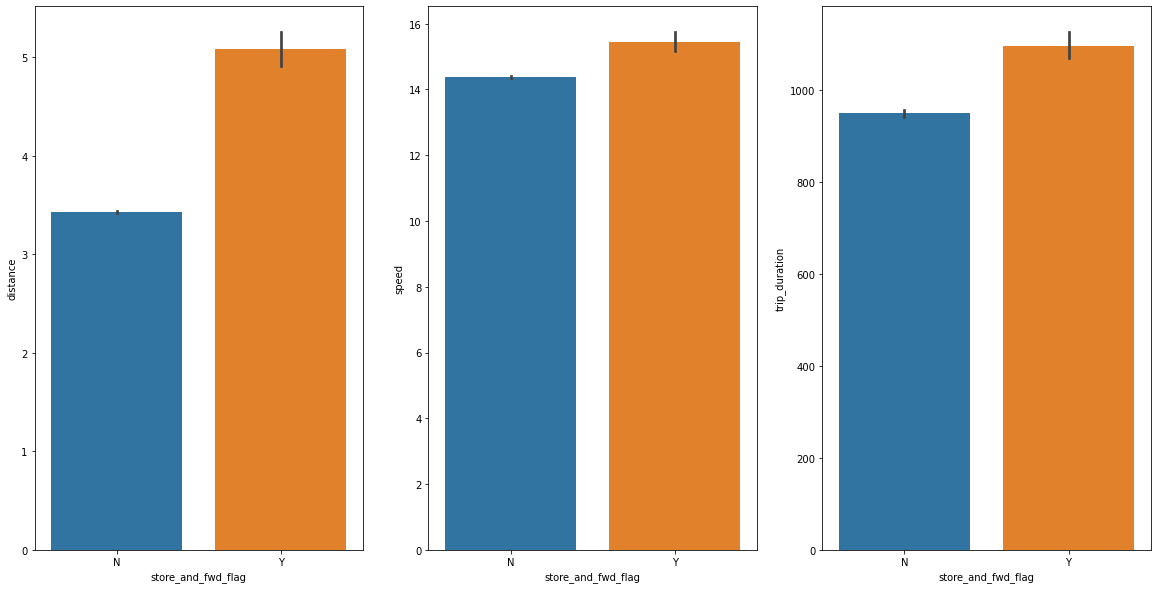

In [123]:
BVA(data, 'store_and_fwd_flag')

Trips with store_and_fwd_flag Y are longer due to longer distance.

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='count'>

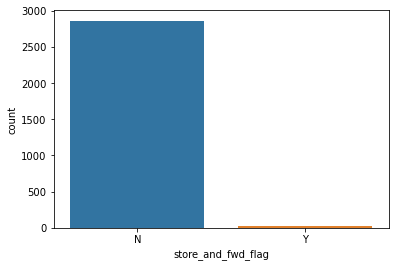

In [130]:
## Looking at flag for trips with distance 0

sns.countplot(data = data.loc[data.distance==0], x = 'store_and_fwd_flag')

Distance 0 has nothing to do with the flag. It probably denotes round trips.

### Pickup Day of Week

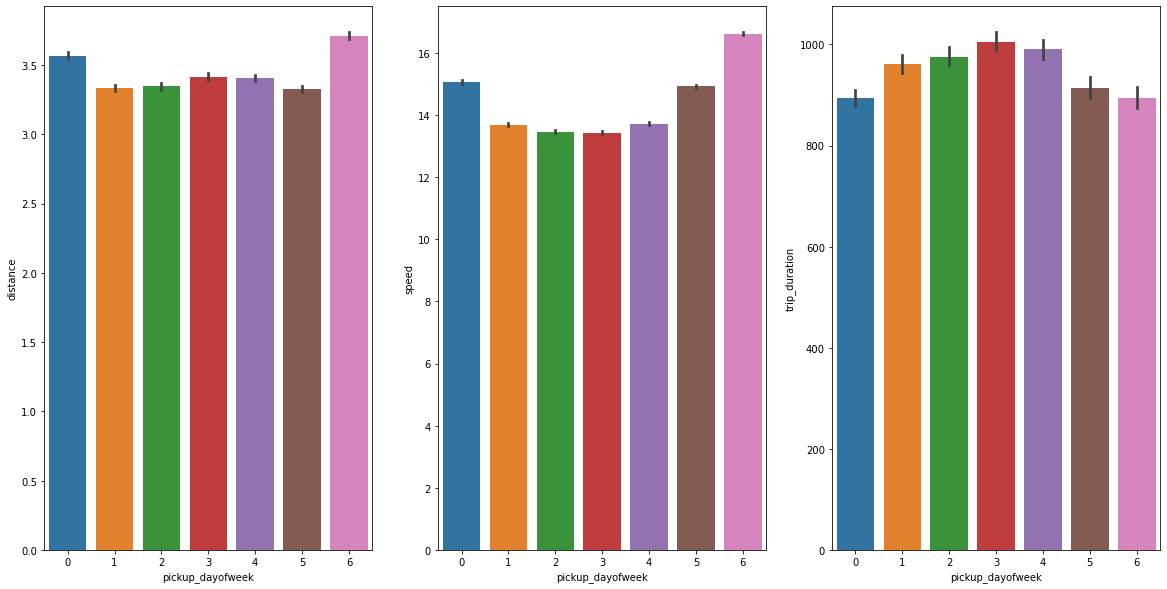

In [131]:
BVA(data, 'pickup_dayofweek')

* In Univariate Analysis, we saw that Friday and Saturday were the busiest with Sunday and Monday being the least busy.
* Sunday and Monday also correspond to longer trips with higher speeds which leads to shorter trip duration than other weekdays.
* Other Weekdays have lower avaerage speeds and therefore higher trip duration.

### Pickup Month

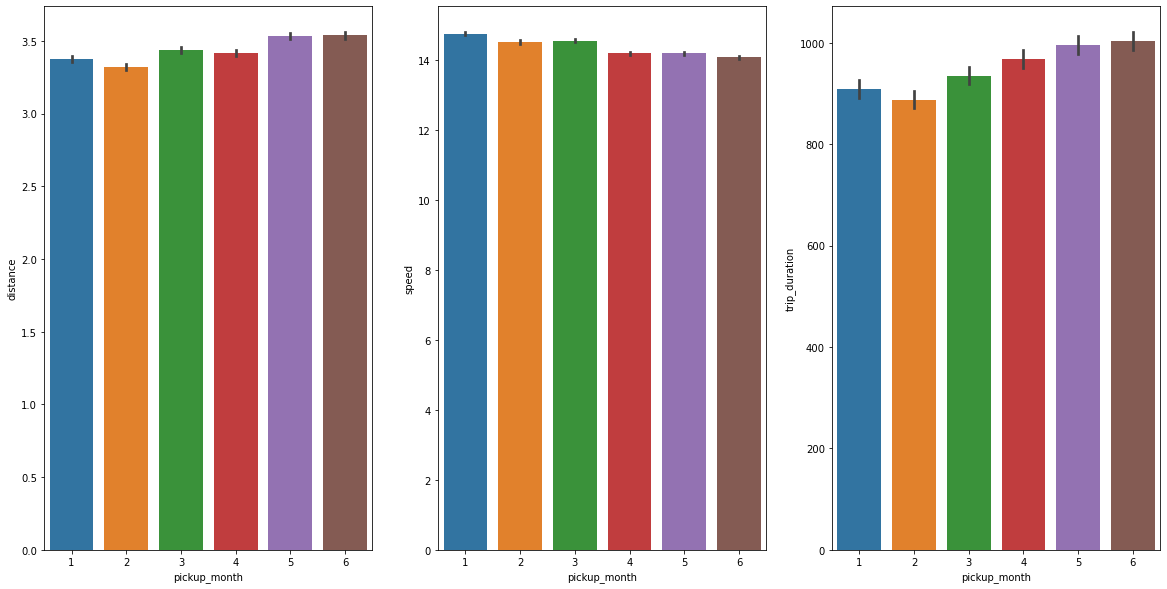

In [132]:
BVA(data, 'pickup_month')

Trips take longer as the year progresses

### Pickup_Hour

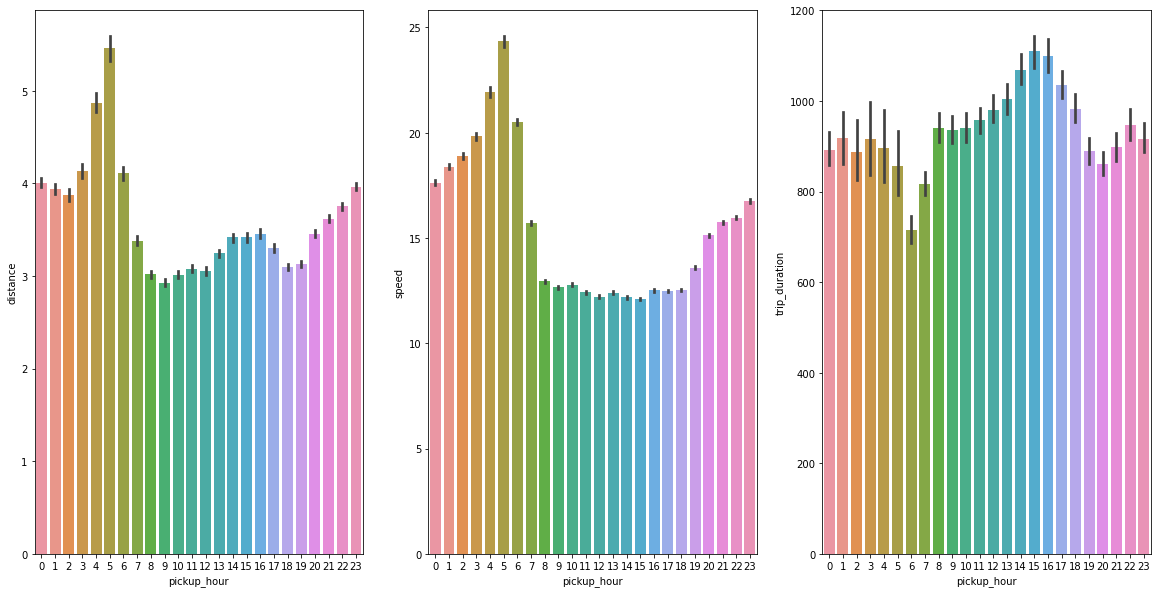

In [133]:
BVA(data, 'pickup_hour')

Trip Duration peaks in the afternoon and is lowest in the morning.

Interestingly, although trips are longer between 4 and 6am, the avaerage speed is also higher leading to no effect in trip duration.

### Pickup Part of Day

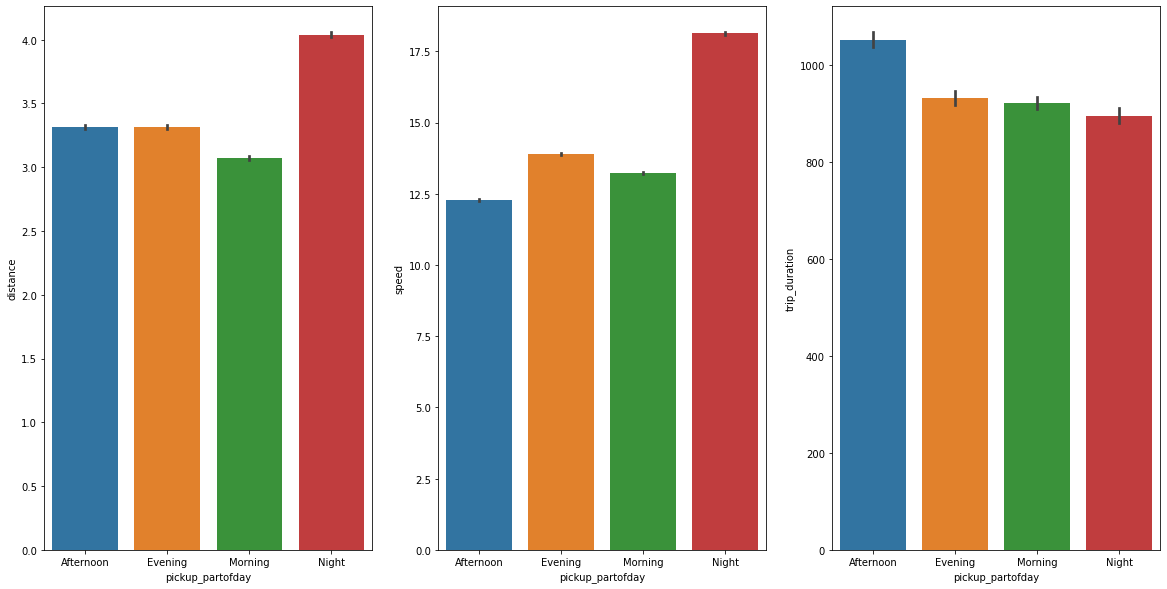

In [134]:
BVA(data, 'pickup_partofday')

Trip Duration is highest at afternoon.

### Passenger Count

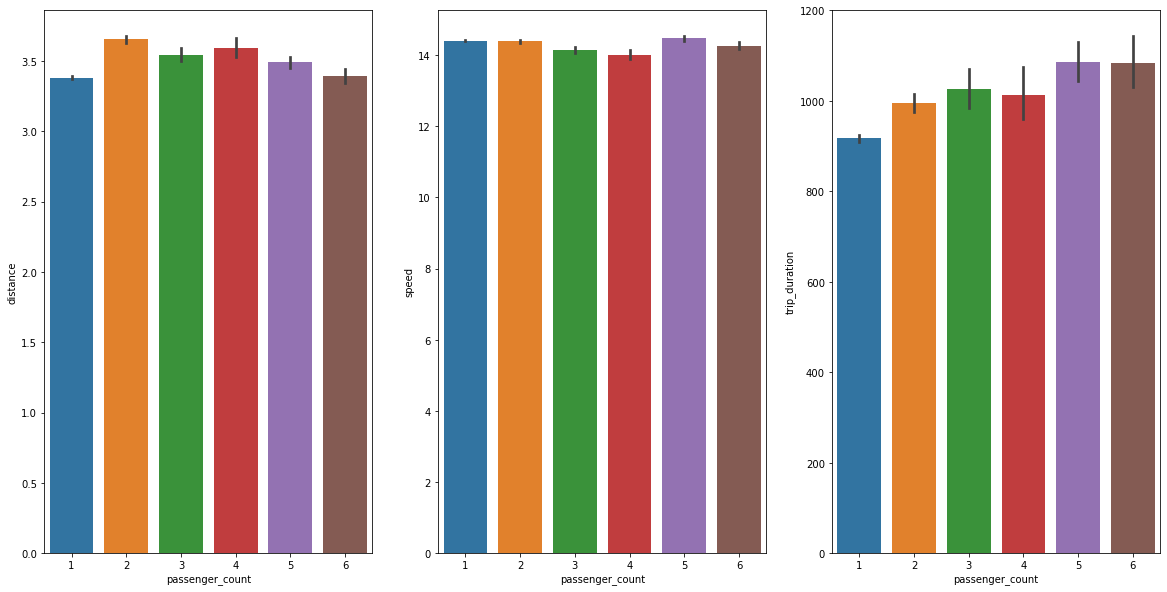

In [222]:
BVA(data, 'passenger_count')

Solo passengers have shorter trips both in terms of distance and duration.

## New Variables For Manhattan Area and JFK Airport

In [214]:
def airport (lat1, long1, lat2, long2):
    if (lat1>40.625)&(lat1<40.675)&(long1>-73.81)&(long1<-73.78):
        return 1
    elif (lat2>40.625)&(lat2<40.675)&(long2>-73.81)&(long2<-73.78):
        return 1
    else:
        return 0

data['airport'] = data.apply(lambda x : airport(x['pickup_latitude'],
                                                x['pickup_longitude'],
                                                x['dropoff_latitude'],
                                                x['dropoff_longitude']
                                                ),axis = 1)

In [215]:
def manhattan (lat1, long1, lat2, long2):
    if (lat1>40.7)&(lat1>(long1+114.7))&(long1>(lat1-114.8))&(long1<-73.93)&(long1>-74.02):
        flag1 = True
    else:
        flag1 = False
    if (lat2>40.7)&(lat2>(long2+114.7))&(long2>(lat2-114.8))&(long2<-73.93)&(long2>-74.02):
        flag2 = True
    else:
        flag2 = False
    if flag1&flag2:
        return 1
    else:
        return 0

data['manhattan'] = data.apply(lambda x : manhattan(x['pickup_latitude'],
                                                x['pickup_longitude'],
                                                x['dropoff_latitude'],
                                                x['dropoff_longitude']
                                                ),axis = 1)

### Distance to the airport

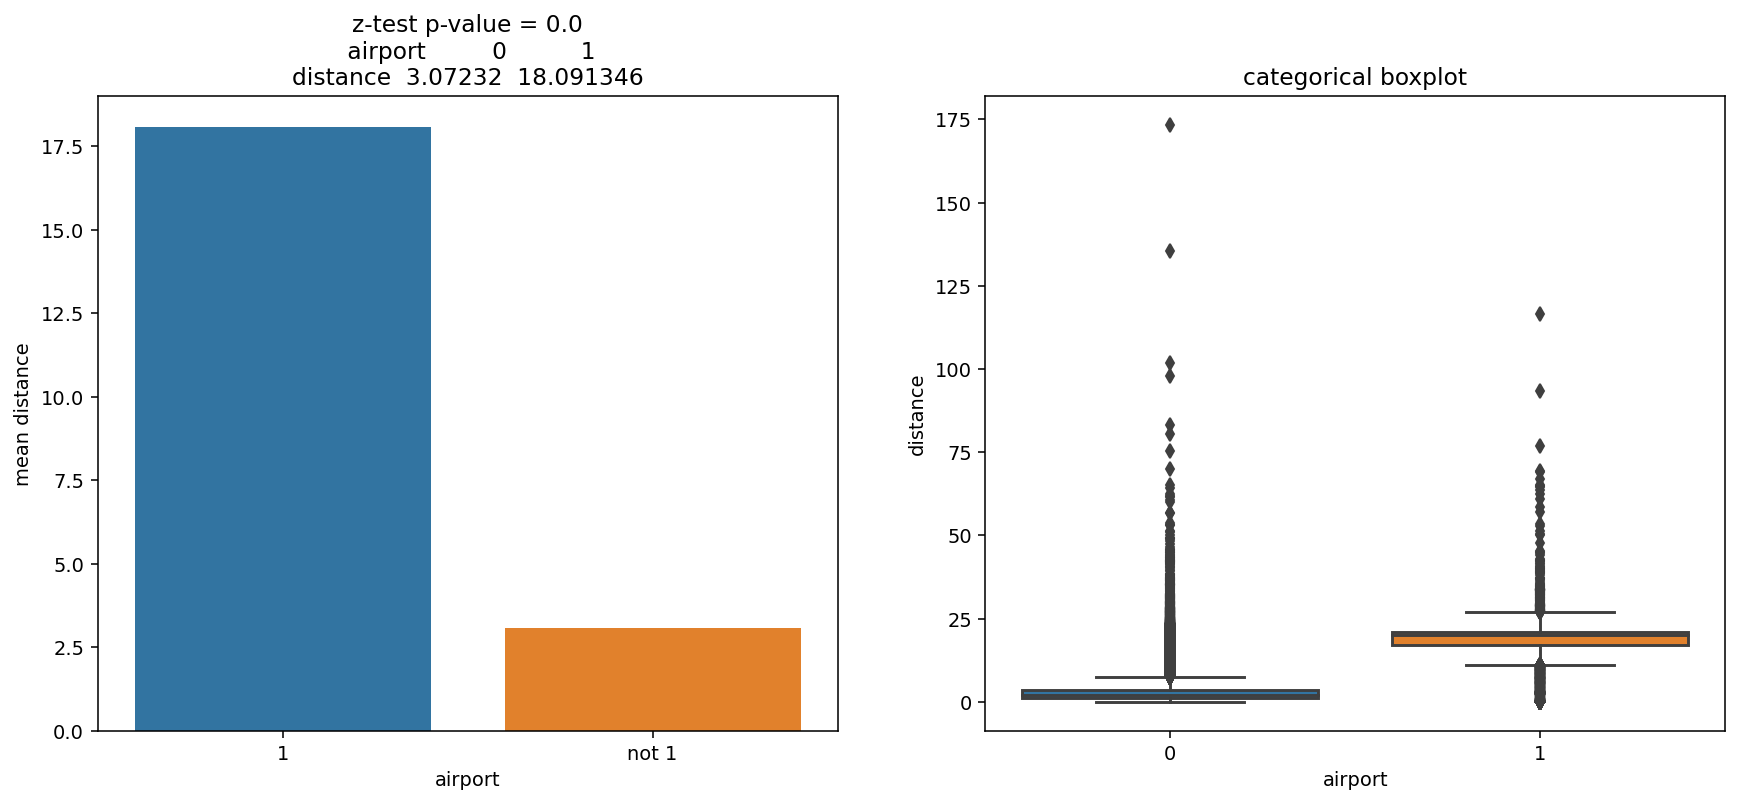

In [216]:
BVA_cont_cat(data, 'distance', 'airport', 1)

<AxesSubplot:xlabel='distance', ylabel='Density'>

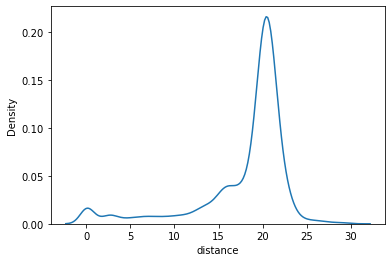

In [217]:
sns.kdeplot(data=data.loc[(data.airport==1)&(data.distance<30)], x='distance')

This explains the 20.5 km peak

### Speed to the airport

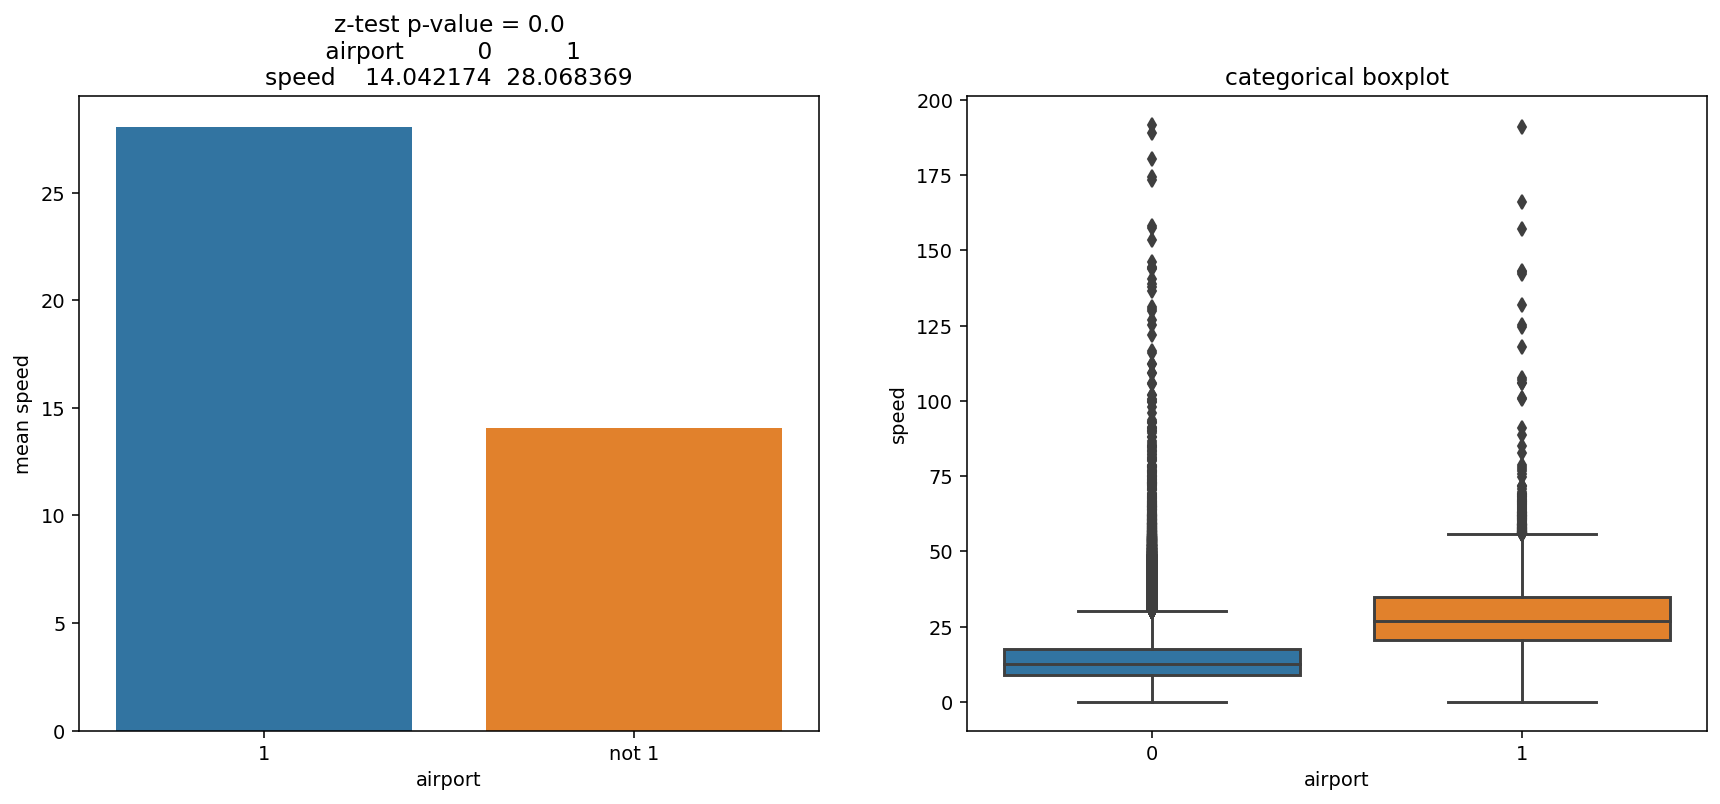

In [218]:
BVA_cont_cat(data, 'speed', 'airport', 1)

Average speed to and from airport is significantly faster as expected.

### Speed in Manhattan

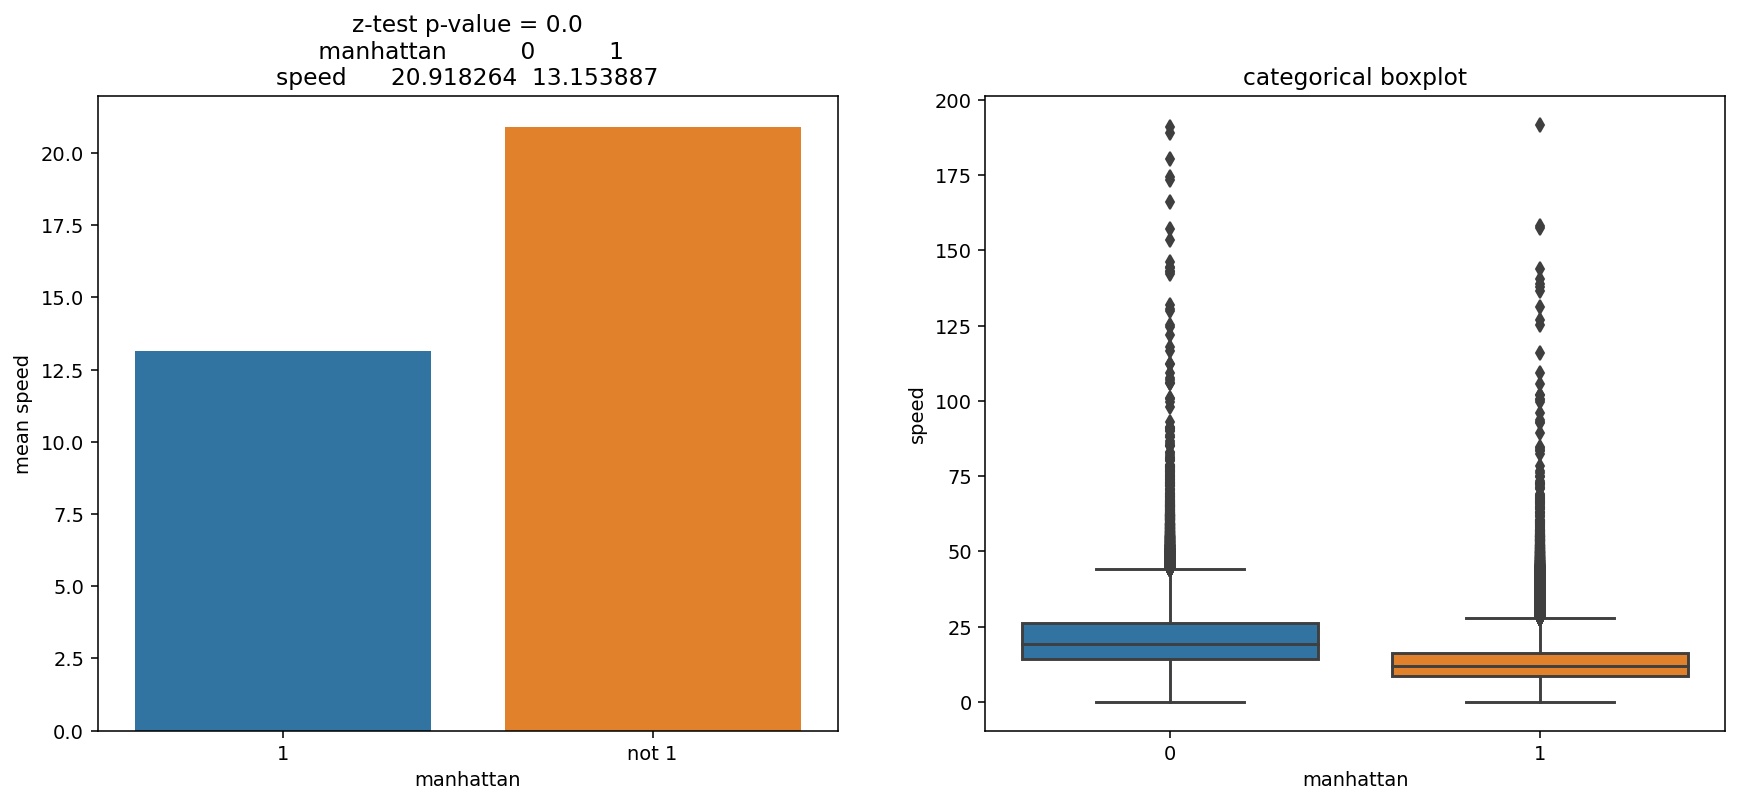

In [219]:
BVA_cont_cat(data, 'speed', 'manhattan', 1)

Average speed in Manhattan is lower.

In [223]:
data.drop(columns = ['airport', 'manhattan'], inplace = True)

## Bivariate : Categorical-Categorical

In [227]:
def BVA_categorical_plot(data, tar, cat):
  '''
  take data and two categorical variables,
  calculates the chi2 significance between the two variables 
  and prints the result with countplot & CrossTab
  '''
  #isolating the variables
  data = data[[cat,tar]][:]

  #forming a crosstab
  table = pd.crosstab(data[tar],data[cat],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  #performing chi2 test
  from scipy.stats import chi2_contingency
  chi, p, dof, expected = chi2_contingency(f_obs)
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False

  #plotting percent stacked bar plot
  ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack()
  ax1.plot(kind='bar', stacked='True')
  plt.title("p-value = {}\n difference significant? = {}\n{}".format(round(p,8),sig,str(ax1)))


### Vendor ID and Store&Forward Flag

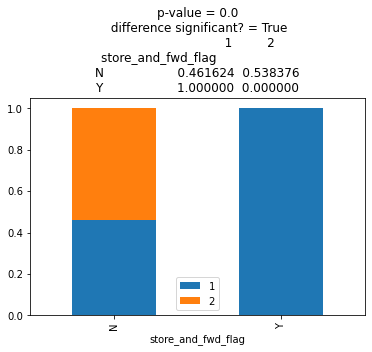

In [228]:
BVA_categorical_plot(data, 'vendor_id', 'store_and_fwd_flag')

All cases of store_and_fwd_flag Y is with vendor 1.

### Vendor ID and Passenger Count

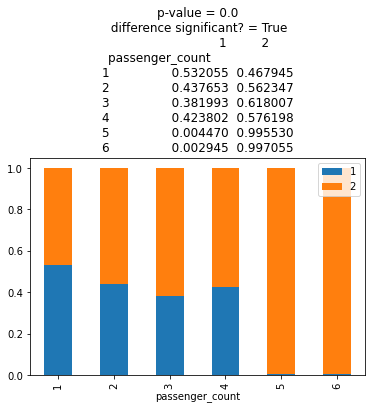

In [231]:
BVA_categorical_plot(data, 'vendor_id', 'passenger_count')

Almost all trips with 5 or 6 passengers are with vendor 2.